#### NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 8 - Mini projects (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. Here, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

=========================================================================================

From BrainScore "resnet50_barlow" is ranked 1st for alignment on IT data from MajajHong2015. "layer4.0" is best aligned on IT.

https://www.brain-score.org/model/vision/1310

https://github.com/facebookresearch/barlowtwins


In [1]:
from brainlike.utils import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import StratifiedKFold
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_to_data = 'brainlike/'
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)
x_train = stimulus_train.reshape((stimulus_train.shape[0], -1))
x_val = stimulus_val.reshape((stimulus_val.shape[0], -1))
n_stimulus = stimulus_train.shape[0]

model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model = model.to(device)
model.eval()

print(f"Computation on {device}.")

/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
Using cache found in /home/ennassih/.cache/torch/hub/facebookresearch_barlowtwins_main
/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ennassih/brainlike_venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Computation on cuda.


In [2]:
return_node = 'layer4.0'

imgs_tr = torch.from_numpy(stimulus_train).to(device)
imgs_val = torch.from_numpy(stimulus_val).to(device)

with torch.no_grad():
    print(f"Extracting {return_node}:")
    
    # Forward training set
    extractor = create_feature_extractor(model, return_nodes={return_node:return_node})
    activation_tr = extractor(imgs_tr)[return_node]
    activation_tr = activation_tr.flatten(1)

    print(f"   Fitting PCA on training set {tuple(activation_tr.shape)}...")
    U, S, V = torch.pca_lowrank(activation_tr, 1000) # components may be approximate
    activation_tr = (activation_tr @ V).cpu()
    print(f"   Extracted reduced training activations {tuple(activation_tr.shape)}.")
    del U, S

    # Forward validation set
    activation_val = extractor(imgs_val)[return_node]
    activation_val = (activation_val.flatten(1) @ V).cpu()
    print(f"   Extracted reduced validation activations {tuple(activation_val.shape)}.")
    del extractor, V

    torch.cuda.empty_cache()


Extracting layer4.0:
   Fitting PCA on training set (2592, 100352)...
   Extracted reduced training activations (2592, 1000).
   Extracted reduced validation activations (288, 1000).


CROSS-VALIDATION :


100%|█████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


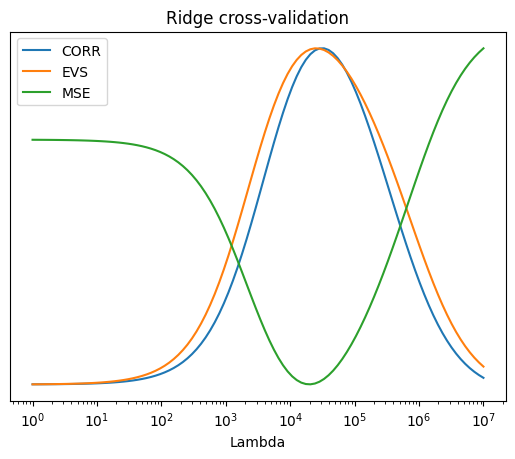

In [3]:


lbds = np.logspace(0, 7, 100)
skf = StratifiedKFold()

evs, corrs, mses = [], [], []

print("CROSS-VALIDATION :")
for i in tqdm(range(len(lbds))):

    ev_lbd, corr_lbd, mse_lbd = 0, 0, 0

    for j, (tr_idx, val_idx) in enumerate(skf.split(x_train, objects_train)):
        # Use PC for better fit
        x_tr_fold = activation_tr[tr_idx]
        x_val_fold = activation_tr[val_idx]
        y_tr_fold = spikes_train[tr_idx]
        y_val_fold = spikes_train[val_idx]

        reg_fold = Ridge(lbds[i])
        reg_fold.fit(x_tr_fold, y_tr_fold)
        y_pred_fold = reg_fold.predict(x_val_fold)

        # Fold metrics are explained variance, mean neuron correlation and mse 
        ev_lbd += explained_variance_score(y_val_fold, y_pred_fold)
        corr_lbd += np.mean([np.corrcoef(y_val_fold[:,neuron], y_pred_fold[:,neuron])[0,1] for neuron in range(y_pred_fold.shape[1])])
        mse_lbd += mean_squared_error(y_val_fold, y_pred_fold)

    evs.append(ev_lbd/5)
    corrs.append(corr_lbd/5)
    mses.append(mse_lbd/5)

norm = lambda x: (x-min(x))/(max(x)-min(x))

plt.plot(lbds, norm(corrs), label='CORR')
plt.plot(lbds, norm(evs), label='EVS')
plt.plot(lbds, norm(mses), label='MSE')
plt.title("Ridge cross-validation")
plt.xlabel("Lambda")
plt.legend()
plt.xscale('log')
plt.yticks([])
plt.show()


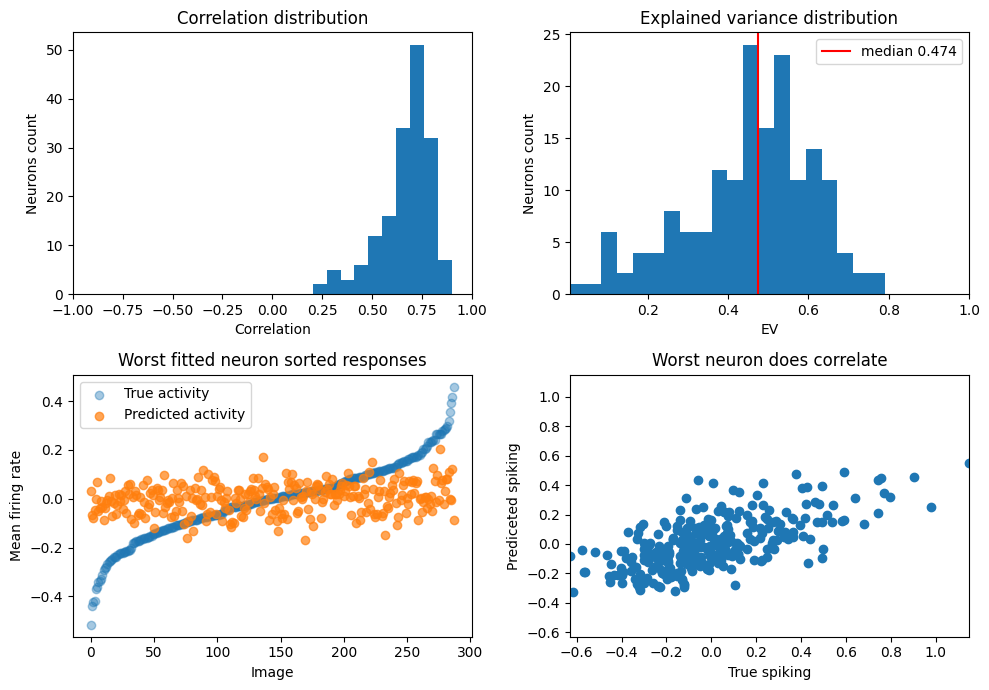

In [4]:
reg = Ridge(lbds[np.argmin(mses)])
reg.fit(activation_tr, spikes_train)
y_pred = reg.predict(activation_val)

ev_scores = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
corr_scores = [np.corrcoef(spikes_val[:,neuron], y_pred[:,neuron])[0,1] for neuron in range(y_pred.shape[1])]

f, axs = plt.subplots(2,2, figsize=(10,7))

axs[0,0].set_title('Correlation distribution')
axs[0,0].hist(corr_scores, bins=10)
axs[0,0].set_xlabel('Correlation')
axs[0,0].set_ylabel('Neurons count')
axs[0,0].set_xlim((-1, 1))

axs[0,1].set_title('Explained variance distribution')
axs[0,1].hist(ev_scores, bins=20)
axs[0,1].set_xlabel('EV')
axs[0,1].set_ylabel('Neurons count')
axs[0,1].set_xlim((min(ev_scores), 1))
ev_median = np.median(ev_scores)
axs[0,1].axvline(ev_median, c='red', label=f'median {ev_median:.3f}')
axs[0,1].legend()


worst = np.argmin(corr_scores)

axs[1,0].set_title('Worst fitted neuron sorted responses')
worst_neuron = spikes_val[:, worst]
argsorts_worst = np.argsort(worst_neuron)
images = np.arange(len(worst_neuron))
axs[1,0].scatter(images, worst_neuron[argsorts_worst], label='True activity', alpha=0.4)
axs[1,0].scatter(images, y_pred[argsorts_worst,worst], label='Predicted activity', alpha=0.7)
axs[1,0].set_xlabel('Image')
axs[1,0].set_ylabel('Mean firing rate')
axs[1,0].legend()

axs[1,1].set_title('Worst neuron does correlate')
x_min, x_max = np.min((spikes_val[:,37], y_pred[:,37])), np.max((spikes_val[:,37], y_pred[:,37]))
axs[1,1].scatter(spikes_val[:,37], y_pred[:,37])
axs[1,1].set_xlim(x_min, x_max)
axs[1,1].set_ylim(x_min, x_max)
axs[1,1].set_xlabel('True spiking')
axs[1,1].set_ylabel('Prediceted spiking')

plt.tight_layout()
plt.show()